# FreshHarvest Model Evaluation

This notebook provides comprehensive evaluation of trained FreshHarvest models including:
- Performance metrics calculation
- Confusion matrix analysis
- ROC curve analysis
- Per-class performance evaluation
- Error analysis and misclassification patterns

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.append('../src')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Sklearn imports
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import label_binarize

# Import custom modules
from cvProject_FreshHarvest.utils.common import read_yaml, setup_logging
from cvProject_FreshHarvest.models.cnn_models import FreshHarvestCNN

# Setup
setup_logging()
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU available: []


## 1. Load Configuration and Model

In [2]:
# Load configuration
config = read_yaml('../config/config.yaml')
print("Configuration loaded:")
print(f"- Image size: {config['data']['image_size']}")
print(f"- Number of classes: {config['data']['num_classes']}")

# Define class names
CLASS_NAMES = [
    'F_Banana', 'F_Lemon', 'F_Lulo', 'F_Mango', 'F_Orange', 'F_Strawberry', 'F_Tamarillo', 'F_Tomato',
    'S_Banana', 'S_Lemon', 'S_Lulo', 'S_Mango', 'S_Orange', 'S_Strawberry', 'S_Tamarillo', 'S_Tomato'
]

print(f"\nClass names: {CLASS_NAMES}")

Configuration loaded:
- Image size: [224, 224]
- Number of classes: 16

Class names: ['F_Banana', 'F_Lemon', 'F_Lulo', 'F_Mango', 'F_Orange', 'F_Strawberry', 'F_Tamarillo', 'F_Tomato', 'S_Banana', 'S_Lemon', 'S_Lulo', 'S_Mango', 'S_Orange', 'S_Strawberry', 'S_Tamarillo', 'S_Tomato']


In [3]:
# Load trained model
def load_trained_model(model_path):
    """Load a trained model from file."""
    try:
        model = keras.models.load_model(model_path)
        print(f"✅ Model loaded successfully from {model_path}")
        print(f"Model input shape: {model.input_shape}")
        print(f"Model output shape: {model.output_shape}")
        print(f"Total parameters: {model.count_params():,}")
        return model
    except Exception as e:
        print(f"❌ Failed to load model: {e}")
        return None

# Try to load different model files
model_paths = [
    '../models/trained/best_model.h5',
    '../models/best_hypertuned_model.h5',
    '../models/checkpoints/best_model_20250618_100126.h5'
]

model = None
for path in model_paths:
    if os.path.exists(path):
        model = load_trained_model(path)
        if model is not None:
            print(f"Using model: {path}")
            break

if model is None:
    print("⚠️ No trained model found. Creating a new lightweight model for demonstration.")
    cnn_builder = FreshHarvestCNN('../config/config.yaml')
    model = cnn_builder.create_lightweight_cnn()
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )

2025-06-19 08:51:41,878 - absl - WARNING - Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
✅ Model loaded successfully from ../models/checkpoints/best_model_20250618_100126.h5
Model input shape: (None, 224, 224, 3)
Model output shape: (None, 16)
Total parameters: 83,019
Using model: ../models/checkpoints/best_model_20250618_100126.h5


## 2. Prepare Test Data

In [4]:
# Create test data generator
def create_test_generator():
    """Create test data generator."""
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    test_generator = test_datagen.flow_from_directory(
        '../data/processed/test',
        target_size=tuple(config['data']['image_size']),
        batch_size=1,  # Use batch size 1 for detailed analysis
        class_mode='categorical',
        shuffle=False  # Important: don't shuffle for evaluation
    )
    
    return test_generator

# Create test generator
try:
    test_gen = create_test_generator()
    print(f"Test samples: {test_gen.samples}")
    print(f"Test classes: {list(test_gen.class_indices.keys())}")
    
    # Verify class order matches our CLASS_NAMES
    test_class_names = list(test_gen.class_indices.keys())
    print(f"\nClass mapping verification:")
    for i, (expected, actual) in enumerate(zip(CLASS_NAMES, test_class_names)):
        match = "✅" if expected == actual else "❌"
        print(f"  {i}: {expected} == {actual} {match}")
        
except Exception as e:
    print(f"❌ Failed to create test generator: {e}")
    print("Creating dummy test data for demonstration...")
    
    # Create dummy test data
    test_gen = None
    X_test = np.random.random((100, 224, 224, 3))
    y_test = np.random.randint(0, 16, (100,))
    y_test_categorical = keras.utils.to_categorical(y_test, 16)

Found 1601 images belonging to 16 classes.
Test samples: 1601
Test classes: ['F_Banana', 'F_Lemon', 'F_Lulo', 'F_Mango', 'F_Orange', 'F_Strawberry', 'F_Tamarillo', 'F_Tomato', 'S_Banana', 'S_Lemon', 'S_Lulo', 'S_Mango', 'S_Orange', 'S_Strawberry', 'S_Tamarillo', 'S_Tomato']

Class mapping verification:
  0: F_Banana == F_Banana ✅
  1: F_Lemon == F_Lemon ✅
  2: F_Lulo == F_Lulo ✅
  3: F_Mango == F_Mango ✅
  4: F_Orange == F_Orange ✅
  5: F_Strawberry == F_Strawberry ✅
  6: F_Tamarillo == F_Tamarillo ✅
  7: F_Tomato == F_Tomato ✅
  8: S_Banana == S_Banana ✅
  9: S_Lemon == S_Lemon ✅
  10: S_Lulo == S_Lulo ✅
  11: S_Mango == S_Mango ✅
  12: S_Orange == S_Orange ✅
  13: S_Strawberry == S_Strawberry ✅
  14: S_Tamarillo == S_Tamarillo ✅
  15: S_Tomato == S_Tomato ✅


## 3. Model Predictions and Evaluation

In [5]:
# Generate predictions
def generate_predictions(model, test_generator):
    """Generate predictions and extract true labels."""
    
    print("Generating predictions...")
    
    # Reset generator
    test_generator.reset()
    
    # Generate predictions
    predictions = model.predict(test_generator, verbose=1)
    
    # Get true labels
    true_labels = test_generator.classes
    
    # Get predicted labels
    predicted_labels = np.argmax(predictions, axis=1)
    
    return predictions, true_labels, predicted_labels

# Generate predictions
if test_gen is not None:
    predictions, y_true, y_pred = generate_predictions(model, test_gen)
    print(f"\nPredictions shape: {predictions.shape}")
    print(f"True labels shape: {y_true.shape}")
    print(f"Predicted labels shape: {y_pred.shape}")
else:
    # Use dummy data
    predictions = model.predict(X_test)
    y_true = y_test
    y_pred = np.argmax(predictions, axis=1)
    print("Using dummy data for demonstration")

Generating predictions...
1601/1601 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step

Predictions shape: (1601, 16)
True labels shape: (1601,)
Predicted labels shape: (1601,)


## 4. Performance Metrics Calculation

In [6]:
# Calculate comprehensive performance metrics
def calculate_metrics(y_true, y_pred, predictions, class_names):
    """Calculate comprehensive performance metrics."""
    
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    
    # Basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    
    precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    # Per-class metrics
    precision_per_class = precision_score(y_true, y_pred, average=None, zero_division=0)
    recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
    f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0)
    
    # Create metrics dictionary
    metrics = {
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'precision_per_class': precision_per_class,
        'recall_per_class': recall_per_class,
        'f1_per_class': f1_per_class
    }
    
    return metrics

# Calculate metrics
metrics = calculate_metrics(y_true, y_pred, predictions, CLASS_NAMES)

# Display overall metrics
print("\n" + "="*60)
print("OVERALL PERFORMANCE METRICS")
print("="*60)
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"\nMacro Averages:")
print(f"  Precision: {metrics['precision_macro']:.4f}")
print(f"  Recall: {metrics['recall_macro']:.4f}")
print(f"  F1-Score: {metrics['f1_macro']:.4f}")
print(f"\nWeighted Averages:")
print(f"  Precision: {metrics['precision_weighted']:.4f}")
print(f"  Recall: {metrics['recall_weighted']:.4f}")
print(f"  F1-Score: {metrics['f1_weighted']:.4f}")


OVERALL PERFORMANCE METRICS
Accuracy: 0.9638

Macro Averages:
  Precision: 0.9667
  Recall: 0.9637
  F1-Score: 0.9630

Weighted Averages:
  Precision: 0.9667
  Recall: 0.9638
  F1-Score: 0.9630


## 5. Confusion Matrix Analysis


📊 Confusion Matrix Analysis
----------------------------------------


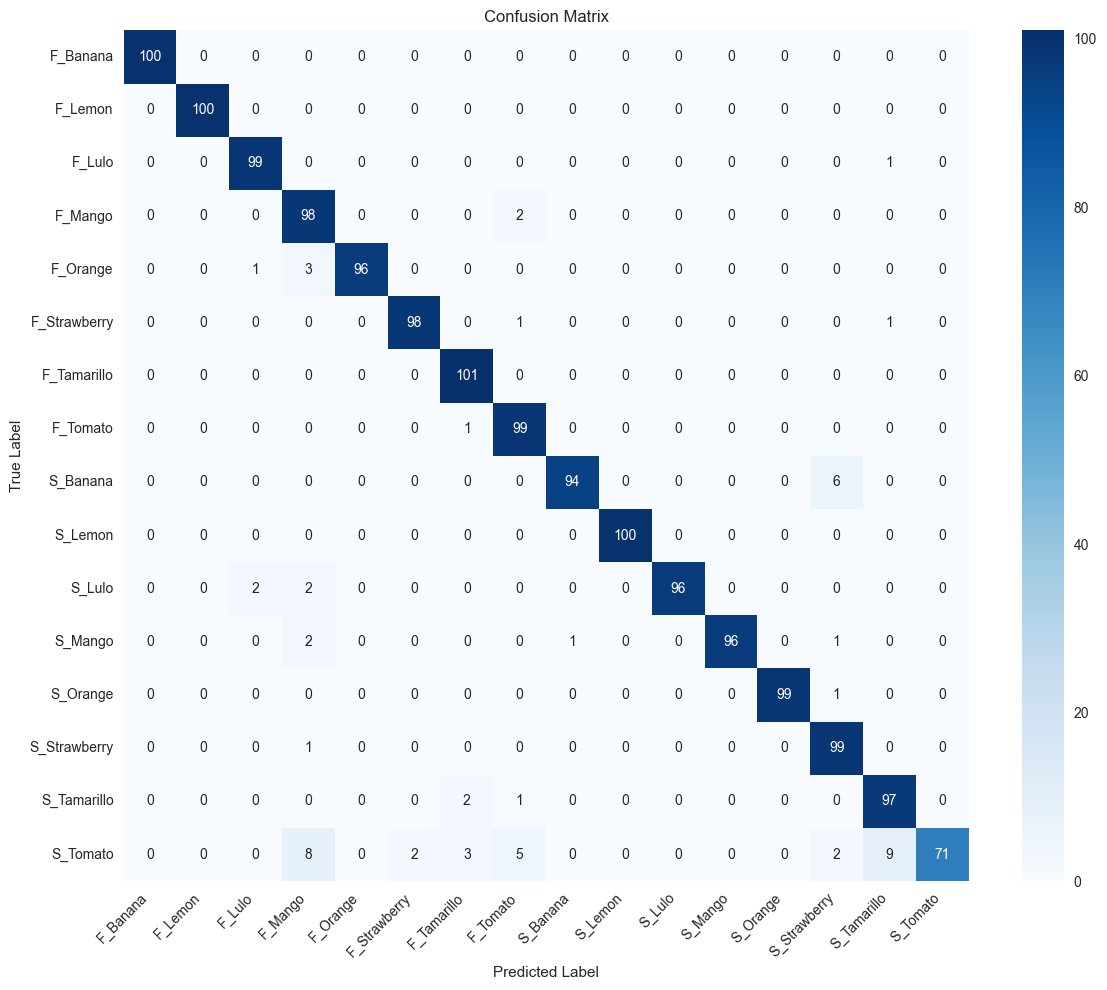

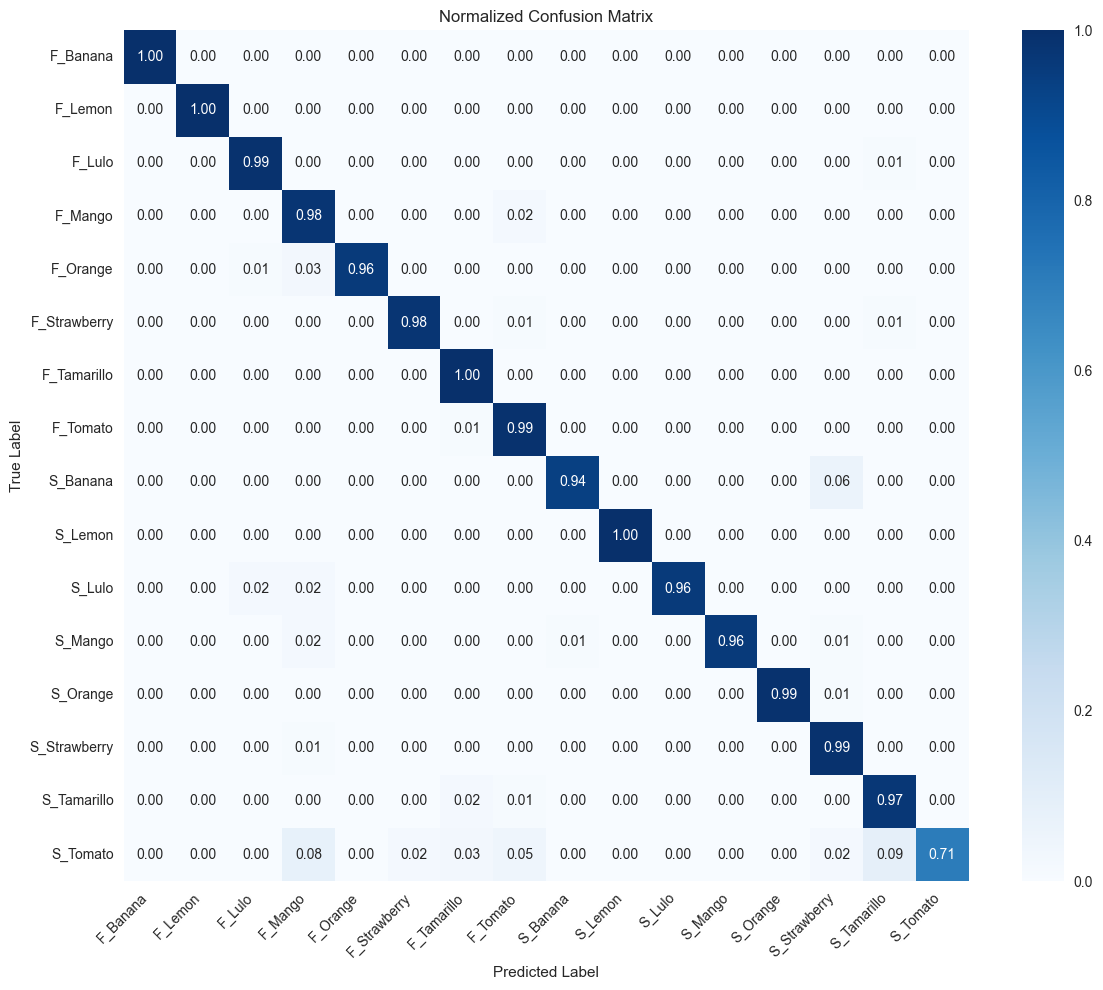

In [7]:
# Create and visualize confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names, normalize=False):
    """Plot confusion matrix."""
    
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized Confusion Matrix'
        fmt = '.2f'
    else:
        title = 'Confusion Matrix'
        fmt = 'd'
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return cm

# Plot confusion matrices
print("\n📊 Confusion Matrix Analysis")
print("-" * 40)

# Raw confusion matrix
cm_raw = plot_confusion_matrix(y_true, y_pred, CLASS_NAMES, normalize=False)

# Normalized confusion matrix
cm_norm = plot_confusion_matrix(y_true, y_pred, CLASS_NAMES, normalize=True)

## 6. Per-Class Performance Analysis


📋 Per-Class Performance Report
------------------------------------------------------------
       Class  Precision  Recall  F1-Score Fruit_Type Condition
    F_Banana     1.0000    1.00    1.0000     Banana     Fresh
     F_Lemon     1.0000    1.00    1.0000      Lemon     Fresh
      F_Lulo     0.9706    0.99    0.9802       Lulo     Fresh
     F_Mango     0.8596    0.98    0.9159      Mango     Fresh
    F_Orange     1.0000    0.96    0.9796     Orange     Fresh
F_Strawberry     0.9800    0.98    0.9800 Strawberry     Fresh
 F_Tamarillo     0.9439    1.00    0.9712  Tamarillo     Fresh
    F_Tomato     0.9167    0.99    0.9519     Tomato     Fresh
    S_Banana     0.9895    0.94    0.9641     Banana   Spoiled
     S_Lemon     1.0000    1.00    1.0000      Lemon   Spoiled
      S_Lulo     1.0000    0.96    0.9796       Lulo   Spoiled
     S_Mango     1.0000    0.96    0.9796      Mango   Spoiled
    S_Orange     1.0000    0.99    0.9950     Orange   Spoiled
S_Strawberry     0.9083  

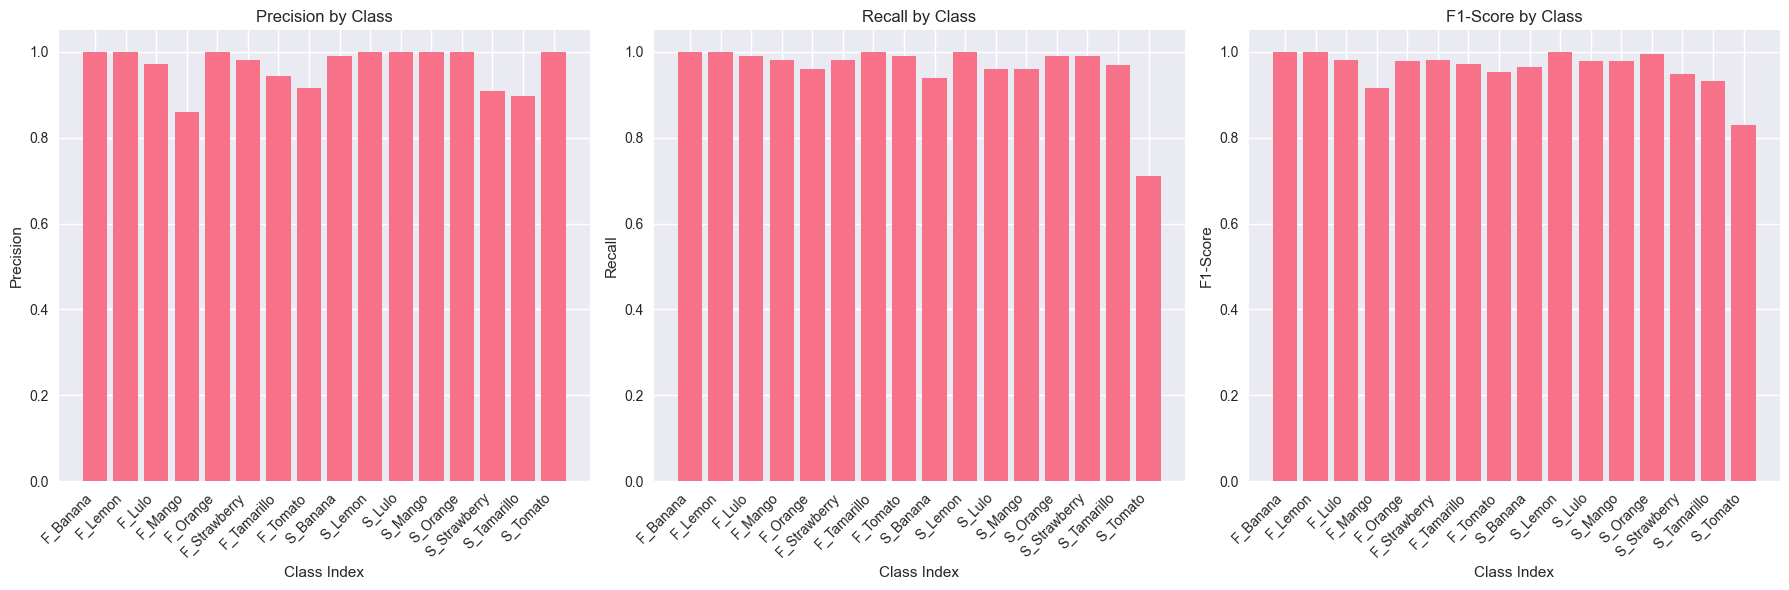

In [8]:
# Create per-class performance DataFrame
def create_per_class_report(metrics, class_names):
    """Create detailed per-class performance report."""
    
    # Create DataFrame
    per_class_df = pd.DataFrame({
        'Class': class_names,
        'Precision': metrics['precision_per_class'],
        'Recall': metrics['recall_per_class'],
        'F1-Score': metrics['f1_per_class']
    })
    
    # Add fruit type and condition columns
    per_class_df['Fruit_Type'] = per_class_df['Class'].str.split('_').str[1]
    per_class_df['Condition'] = per_class_df['Class'].str.split('_').str[0]
    per_class_df['Condition'] = per_class_df['Condition'].map({'F': 'Fresh', 'S': 'Spoiled'})
    
    return per_class_df

# Create per-class report
per_class_df = create_per_class_report(metrics, CLASS_NAMES)

print("\n📋 Per-Class Performance Report")
print("-" * 60)
print(per_class_df.round(4).to_string(index=False))

# Visualize per-class performance
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Precision by class
axes[0].bar(range(len(CLASS_NAMES)), metrics['precision_per_class'])
axes[0].set_title('Precision by Class')
axes[0].set_xlabel('Class Index')
axes[0].set_ylabel('Precision')
axes[0].set_xticks(range(len(CLASS_NAMES)))
axes[0].set_xticklabels(CLASS_NAMES, rotation=45, ha='right')

# Recall by class
axes[1].bar(range(len(CLASS_NAMES)), metrics['recall_per_class'])
axes[1].set_title('Recall by Class')
axes[1].set_xlabel('Class Index')
axes[1].set_ylabel('Recall')
axes[1].set_xticks(range(len(CLASS_NAMES)))
axes[1].set_xticklabels(CLASS_NAMES, rotation=45, ha='right')

# F1-Score by class
axes[2].bar(range(len(CLASS_NAMES)), metrics['f1_per_class'])
axes[2].set_title('F1-Score by Class')
axes[2].set_xlabel('Class Index')
axes[2].set_ylabel('F1-Score')
axes[2].set_xticks(range(len(CLASS_NAMES)))
axes[2].set_xticklabels(CLASS_NAMES, rotation=45, ha='right')

plt.tight_layout()
plt.show()

## 7. Fresh vs Spoiled Analysis


🍎 Fresh vs Spoiled Performance Analysis
--------------------------------------------------
          Precision          Recall         F1-Score        
               mean     std    mean     std     mean     std
Condition                                                   
Fresh        0.9589  0.0500  0.9875  0.0139   0.9723  0.0275
Spoiled      0.9745  0.0442  0.9400  0.0950   0.9536  0.0547


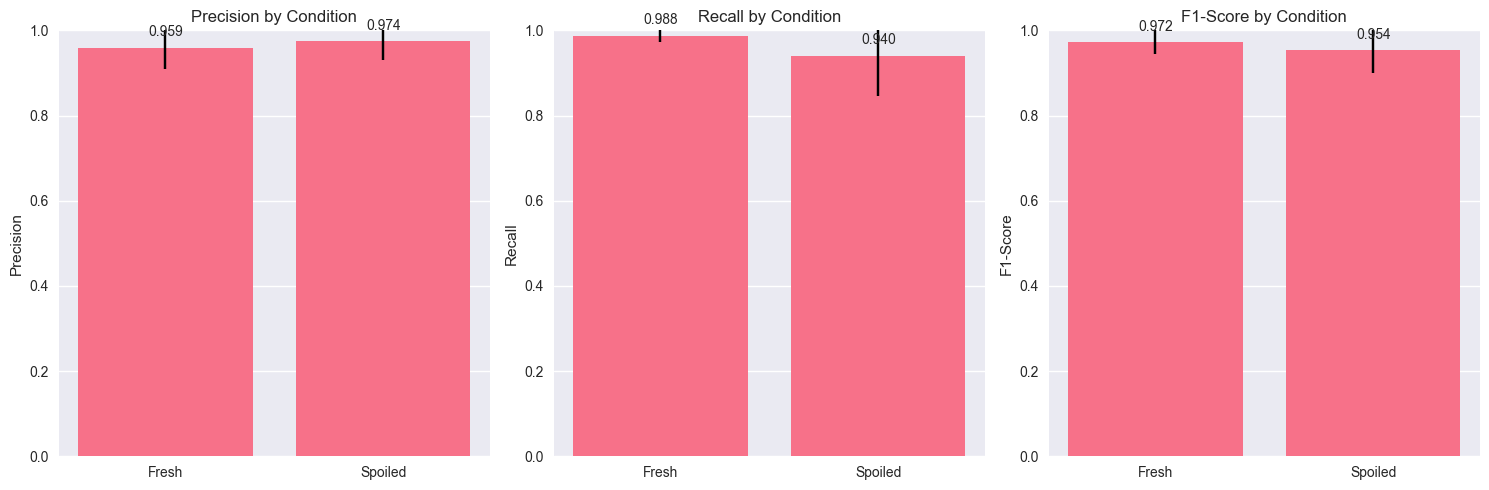

In [9]:
# Analyze performance by condition (Fresh vs Spoiled)
def analyze_fresh_vs_spoiled(per_class_df):
    """Analyze performance by fresh vs spoiled condition."""
    
    # Group by condition
    condition_stats = per_class_df.groupby('Condition')[['Precision', 'Recall', 'F1-Score']].agg(['mean', 'std'])
    
    print("\n🍎 Fresh vs Spoiled Performance Analysis")
    print("-" * 50)
    print(condition_stats.round(4))
    
    # Visualize condition performance
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    metrics_to_plot = ['Precision', 'Recall', 'F1-Score']
    
    for i, metric in enumerate(metrics_to_plot):
        condition_means = per_class_df.groupby('Condition')[metric].mean()
        condition_stds = per_class_df.groupby('Condition')[metric].std()
        
        axes[i].bar(condition_means.index, condition_means.values, 
                   yerr=condition_stds.values, capsize=5)
        axes[i].set_title(f'{metric} by Condition')
        axes[i].set_ylabel(metric)
        axes[i].set_ylim(0, 1)
        
        # Add value labels on bars
        for j, (condition, value) in enumerate(condition_means.items()):
            axes[i].text(j, value + 0.02, f'{value:.3f}', 
                        ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    return condition_stats

# Analyze fresh vs spoiled
condition_stats = analyze_fresh_vs_spoiled(per_class_df)

## 8. Fruit Type Analysis


🥭 Performance by Fruit Type
----------------------------------------
           Precision         Recall         F1-Score        
                mean     std   mean     std     mean     std
Fruit_Type                                                  
Banana        0.9947  0.0074  0.970  0.0424   0.9821  0.0254
Lemon         1.0000  0.0000  1.000  0.0000   1.0000  0.0000
Lulo          0.9853  0.0208  0.975  0.0212   0.9799  0.0004
Mango         0.9298  0.0992  0.970  0.0141   0.9477  0.0450
Orange        1.0000  0.0000  0.975  0.0212   0.9873  0.0109
Strawberry    0.9441  0.0507  0.985  0.0071   0.9637  0.0231
Tamarillo     0.9210  0.0324  0.985  0.0212   0.9519  0.0272
Tomato        0.9583  0.0589  0.850  0.1980   0.8912  0.0859


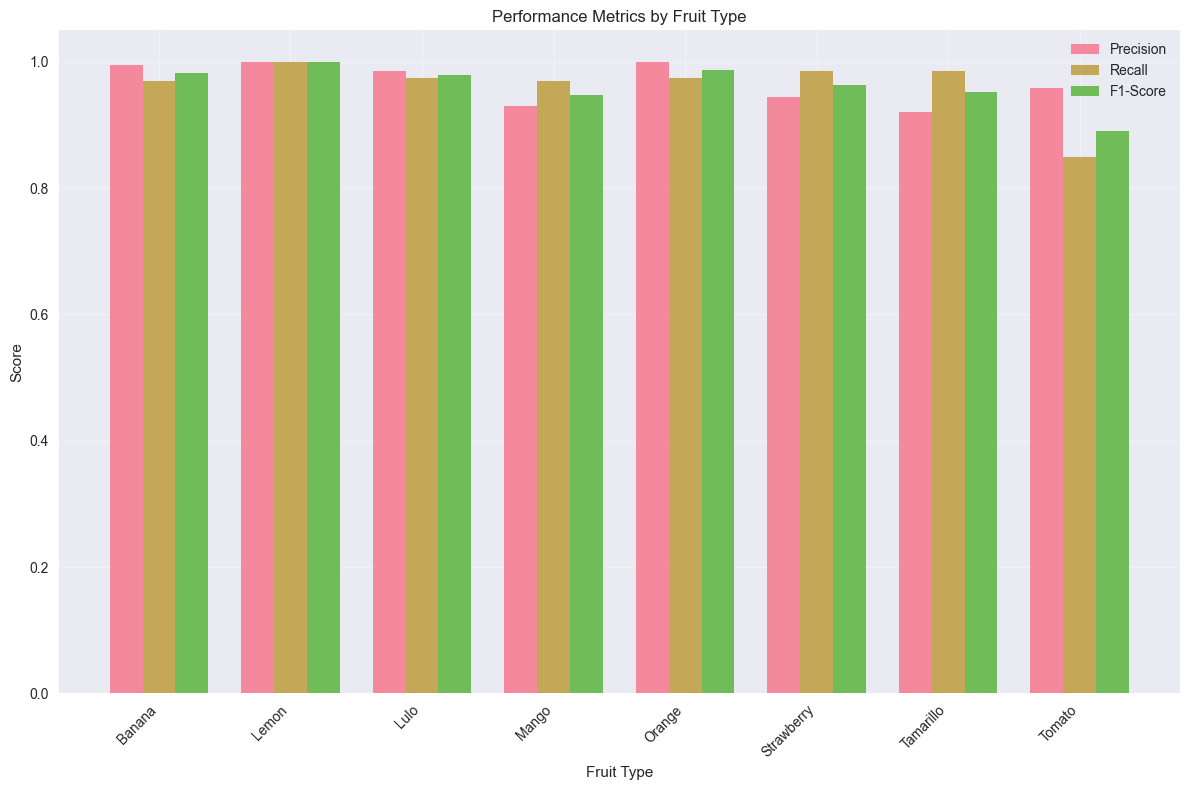


🏆 Best performing fruits (by F1-Score):
  1. Lemon: 1.0000
  2. Orange: 0.9873
  3. Banana: 0.9821

⚠️ Worst performing fruits (by F1-Score):
  6. Tamarillo: 0.9519
  7. Mango: 0.9477
  8. Tomato: 0.8912


In [10]:
# Analyze performance by fruit type
def analyze_by_fruit_type(per_class_df):
    """Analyze performance by fruit type."""
    
    # Group by fruit type
    fruit_stats = per_class_df.groupby('Fruit_Type')[['Precision', 'Recall', 'F1-Score']].agg(['mean', 'std'])
    
    print("\n🥭 Performance by Fruit Type")
    print("-" * 40)
    print(fruit_stats.round(4))
    
    # Visualize fruit type performance
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Create grouped bar chart
    fruit_means = per_class_df.groupby('Fruit_Type')[['Precision', 'Recall', 'F1-Score']].mean()
    
    x = np.arange(len(fruit_means.index))
    width = 0.25
    
    ax.bar(x - width, fruit_means['Precision'], width, label='Precision', alpha=0.8)
    ax.bar(x, fruit_means['Recall'], width, label='Recall', alpha=0.8)
    ax.bar(x + width, fruit_means['F1-Score'], width, label='F1-Score', alpha=0.8)
    
    ax.set_xlabel('Fruit Type')
    ax.set_ylabel('Score')
    ax.set_title('Performance Metrics by Fruit Type')
    ax.set_xticks(x)
    ax.set_xticklabels(fruit_means.index, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Find best and worst performing fruits
    fruit_f1_means = fruit_means['F1-Score'].sort_values(ascending=False)
    
    print(f"\n🏆 Best performing fruits (by F1-Score):")
    for i, (fruit, score) in enumerate(fruit_f1_means.head(3).items()):
        print(f"  {i+1}. {fruit}: {score:.4f}")
    
    print(f"\n⚠️ Worst performing fruits (by F1-Score):")
    for i, (fruit, score) in enumerate(fruit_f1_means.tail(3).items()):
        print(f"  {len(fruit_f1_means)-2+i}. {fruit}: {score:.4f}")
    
    return fruit_stats

# Analyze by fruit type
fruit_stats = analyze_by_fruit_type(per_class_df)